In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import plotly.express as px
px.defaults.width = 600
import plotly.graph_objs as go

from sklearn.datasets import load_iris, make_moons, load_wine, fetch_california_housing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from scipy.stats import reciprocal, uniform

# EXERCISE 9


In [2]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]


In [5]:
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
C = 10
lin_svc = LinearSVC(dual=True, C=C, verbose=1, loss="hinge", random_state=34).fit(
    X_scaled, y
)

svc = SVC(C=5, gamma="auto", verbose=True, kernel="linear", random_state=34).fit(
    X_scaled, y
)

sgdc = SGDClassifier(alpha=0.01, random_state=34).fit(X_scaled, y)
# sgdc.coef_

[LibLinear][LibSVM]

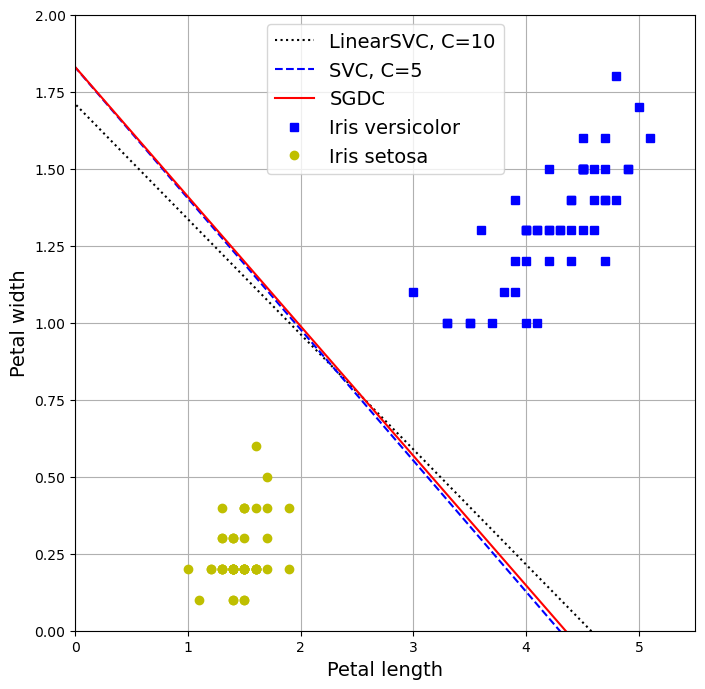

In [6]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])


lin_line = compute_decision_boundary(lin_svc)
svc_line = compute_decision_boundary(svc)
sgdc_line = compute_decision_boundary(sgdc)

plt.figure(figsize=(8, 8))
plt.plot(
    lin_line[:, 0],
    lin_line[:, 1],
    "k:",
    label=f"LinearSVC, C={lin_svc.get_params()['C']}",
)
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", label=f"SVC, C={svc.get_params()['C']}")
plt.plot(sgdc_line[:, 0], sgdc_line[:, 1], "r-", label="SGDC")
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", label="Iris setosa")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

In [7]:
lin_svc.get_params()["C"]


10

# Exercise 10


In [8]:
wine = load_wine(as_frame=True)


In [9]:
print(wine.DESCR)


.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

In [10]:
y.value_counts()


0    50
1    50
Name: target, dtype: int64

In [11]:
X = wine.data.values
X_scaled = StandardScaler().fit_transform(X)
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [12]:
C = 5
one_vs_all_svc = make_pipeline(StandardScaler(),
                               OneVsRestClassifier(SVC(random_state=43)).fit(X_train, y_train))

In [13]:
one_vs_all_svc.get_params()


{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('onevsrestclassifier',
   OneVsRestClassifier(estimator=SVC(random_state=43)))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'onevsrestclassifier': OneVsRestClassifier(estimator=SVC(random_state=43)),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'onevsrestclassifier__estimator__C': 1.0,
 'onevsrestclassifier__estimator__break_ties': False,
 'onevsrestclassifier__estimator__cache_size': 200,
 'onevsrestclassifier__estimator__class_weight': None,
 'onevsrestclassifier__estimator__coef0': 0.0,
 'onevsrestclassifier__estimator__decision_function_shape': 'ovr',
 'onevsrestclassifier__estimator__degree': 3,
 'onevsrestclassifier__estimator__gamma': 'scale',
 'onevsrestclassifier__estimator__kernel': 'rbf',
 'onevsrestclassifier__estimator__max_iter': -1,
 'onevsrestclassifier__estimator__probability': False,
 'onevsrestclassifier__estimator__random_state

In [14]:
cross_val_score(one_vs_all_svc, X_train, y_train).mean()


0.9472934472934472

In [15]:
param_distrib = {
    # "estimator__gamma": reciprocal(0.001, 0.1),
    # "estimator__C": uniform(1, 10),
    "onevsrestclassifier__estimator__gamma": reciprocal(0.001, 0.1),
    "onevsrestclassifier__estimator__C": uniform(1, 10),
    "onevsrestclassifier__estimator__kernel": ["linear", "poly", "rbf", "sigmoid"],
}
rnd_search_cv = RandomizedSearchCV(
    one_vs_all_svc,
    param_distrib,
    n_iter=100,
    cv=5,
    random_state=42,
    scoring="accuracy",
    refit=True,
)
rnd_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('onevsrestclassifier',
                                              OneVsRestClassifier(estimator=SVC(random_state=43)))]),
                   n_iter=100,
                   param_distributions={'onevsrestclassifier__estimator__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000208EBBD6740>,
                                        'onevsrestclassifier__estimator__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000208EBC2ACE0>,
                                        'onevsrestclassifier__estimator__kernel': ['linear',
                                                                                   'poly',
                                                                                   'rbf',
                                                                                   'sigmoid']},
                   random_state=42, scoring='accuracy')

In [16]:
rnd_search_cv.best_score_


0.9774928774928775

In [17]:
accuracy_score(y_test, rnd_search_cv.predict(X_test), normalize=True)


1.0

# EXERCISE 11


In [18]:
housing = fetch_california_housing(as_frame=True)


In [19]:
housing.feature_names


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [20]:
housing.target_names


['MedHouseVal']

In [21]:
housing.data.describe(include="all")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


array([[<AxesSubplot: title={'center': 'MedInc'}>,
        <AxesSubplot: title={'center': 'HouseAge'}>,
        <AxesSubplot: title={'center': 'AveRooms'}>],
       [<AxesSubplot: title={'center': 'AveBedrms'}>,
        <AxesSubplot: title={'center': 'Population'}>,
        <AxesSubplot: title={'center': 'AveOccup'}>],
       [<AxesSubplot: title={'center': 'Latitude'}>,
        <AxesSubplot: title={'center': 'Longitude'}>, <AxesSubplot: >]],
      dtype=object)

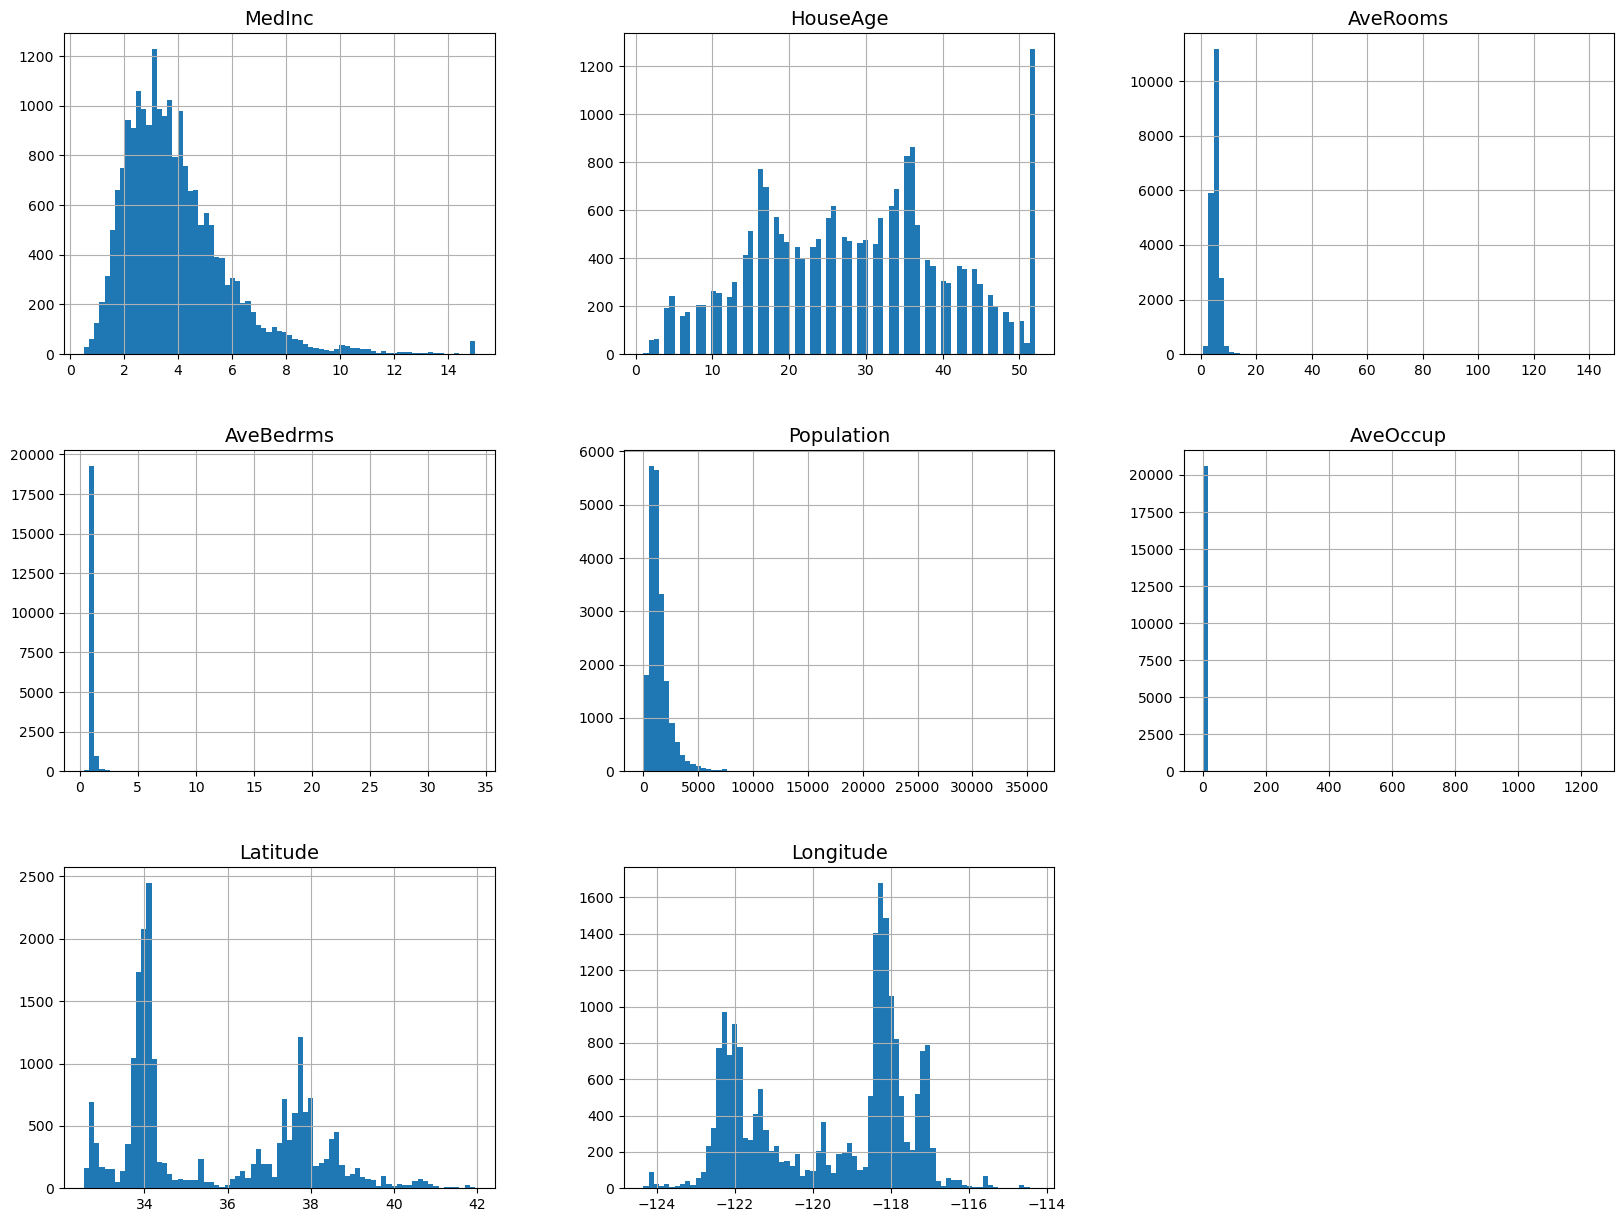

In [22]:
housing.data.hist(figsize=(20, 15), bins=75)

In [23]:
housing = fetch_california_housing()
X = housing.data
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [24]:
svr_housing = make_pipeline(StandardScaler(), LinearSVR(random_state=56, max_iter=10000)).fit(X_train, y_train)


In [25]:
from sklearn.metrics import mean_squared_error

y_pred = svr_housing.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
rmse

0.9768917882377929

In [33]:
sample_size = len(X_train) * 0.2
X_train_sample, y_train_sample = resample(
    X_train, y_train, n_samples=sample_size, stratify=y_train, random_state=42
)



c:\Users\zsena\anaconda3\envs\homl3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [58]:
svr_housing_linear_svr_sample = make_pipeline(StandardScaler(), LinearSVR(random_state=42, max_iter=200000)).fit(
    X_train_sample, y_train_sample
)

param_linear_svr = {
    "linearsvr__C": uniform(0.1, 10),
    "linearsvr__epsilon": uniform(0, 5),
    # "linearsvr__loss": ["epsilon_insensitive", "squared_epsilon_insensitiv"],
}

LinearSVR_cv = RandomizedSearchCV(
    svr_housing_linear_svr_sample,
    param_linear_svr,
    n_iter=25,
    random_state=324,
    scoring="neg_root_mean_squared_error",
    error_score='raise'
).fit(X_train_sample, y_train_sample)
LinearSVR_cv.best_score_


-0.6536014270508984

In [59]:
-cross_val_score(LinearSVR_cv.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.72829406, 0.71427981, 1.78410969, 0.73822421, 0.76597442])

In [60]:
svr_housing_svr_sample = make_pipeline(StandardScaler(),
SVR()).fit(X_train_sample, y_train_sample)

param_svr={
    'svr__gamma': reciprocal(0.001, 1),
    'svr__C': uniform(1, 10)
}

SVR_cv = RandomizedSearchCV(
    svr_housing_svr_sample,
    param_svr,
    n_iter=25,
    random_state=324,
    scoring="neg_root_mean_squared_error",
).fit(X_train_sample, y_train_sample)
SVR_cv.best_score_


-0.5351563040851481

In [62]:
-cross_val_score(SVR_cv.best_estimator_, X_train, y_train,
                 scoring="neg_root_mean_squared_error")

array([0.57346406, 0.55298478, 0.56061009, 0.5536563 , 0.57708346])

In [63]:
y_pred=SVR_cv.best_estimator_.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=True)
rmse

0.321230724456185